In [ ]:
# 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import glob
import time

import PIL
import imageio
import numpy             as np
import tensorflow        as tf
import matplotlib.pyplot as plt
import pandas            as pd

from tensorflow.keras import layers
from IPython          import display
from matplotlib.pylab import rcParams
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

<div style = "height: 50px;"></div>

# STEP 1. 데이터셋 구성하기

In [38]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [39]:
# 이미지 확인하기
train_x.shape

(50000, 32, 32, 3)

가로 32, 세로 32, 3채널(RGB)을 가진 50000개의 이미지임을 확인하였다.

## 로드한 학습 데이터를 시각화

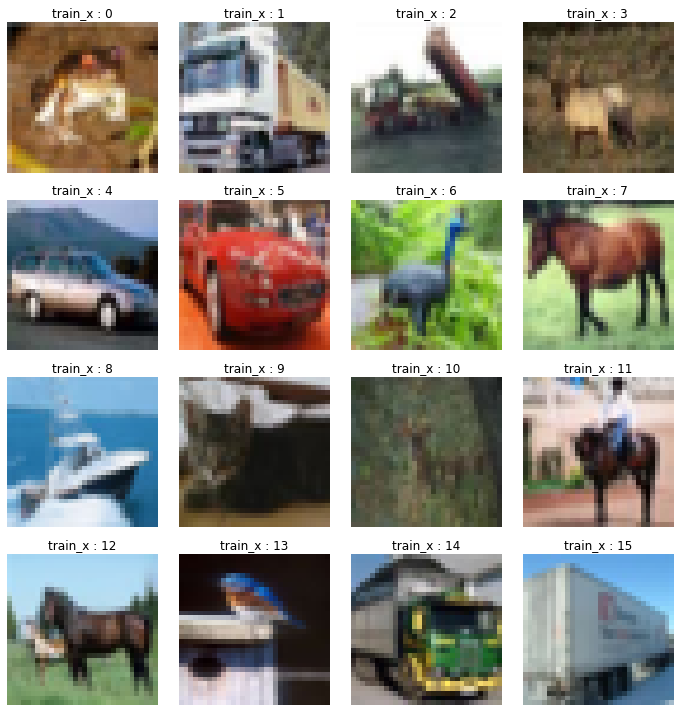

In [40]:
plt.figure(figsize = (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_x[i])
    plt.title(f'train_x : {i}')
    plt.axis('off')
    plt.tight_layout()
    
plt.show()

## train_x의 이미지를 -1, 1로 정규화

In [41]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [42]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [43]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


## from_tensor_slices() 함수를 통해 미니배치 데이터셋을 구성

In [44]:
# 전체 데이터를 섞기 위해 60,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

<div style = "height: 50px;"></div>

# STEP 2. 생성자 모델 구현하기

In [46]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [47]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 128)       

## 구현한 생성자로 랜덤 이미지를 생성

In [48]:
generated_image = generator(tf.random.normal([1, 100]), training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

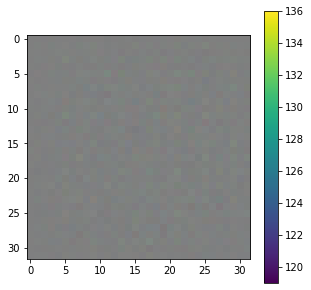

In [49]:
# 생성된 이미지
plt.figure(figsize = (5, 5))
# 정규화한 값을 다시 되돌려서 출력한다. 
plt.imshow(np.int64((generated_image[0] * 127.5) + 127.5))
plt.colorbar() # 정규화를 시켰으므로 -1 ~ 1 사이의 값만 나옴
plt.show()

<div style = "height: 50px;"></div>

# STEP 4. 판별자 모델 구현하기


In [50]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
        
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [51]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)        

## 판별자 모델이 판별한 결과값을 확인

In [52]:
# 아까 생성한 가짜 이미지를 판별자 모델에 입력해보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00022197]], dtype=float32)>

<div style = "height: 50px;"></div>

# STEP 5. 손실함수와 최적화 함수 구현하기

In [53]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [54]:
# generator_loss 구현하기
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [55]:
# discriminator_loss 구현하기
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [56]:
# discriminator accuracy 구현하기
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [57]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [58]:
noise_dim = 100

# 샘플은 한 번에 16장을 생성
num_examples_to_generate = 16

# seed 노이즈 선언
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

<div style = "height: 50px;"></div>

# STEP 6. 훈련과정 상세 기능 구현하기

In [59]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [60]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [61]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

#  epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를
# 그래프로 시각화하는 draw_train_history() 함수

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

<div style = "height: 50px;"></div>

# STEP 7. 학습 과정 진행하기

In [ ]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# 5마다 저장함
save_every = 5
EPOCHS = 2000

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

KeyboardInterrupt: ignored

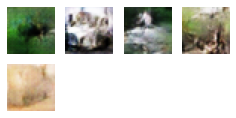

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

정확도가 0.5로 수렴하지 못하는 것을 확인하여 중단하였다.

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_1차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_1차시도.gif" style = "float:left; width:66%;">

<div style = "height: 50px;"></div>

# 2차 시도

## 설명
<hr/>

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">BATCH_SIZE</span> : 512로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : dropout 0.5로 모두 변경하기</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">EPOCHS</span> : 300으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">generator_optimizer</span> : 1e-5로 변경</li>
</ul>

<div style = "height: 50px;"></div>

In [ ]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [ ]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [ ]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 512

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 생성자 모델
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_18 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 8, 8, 128)      

In [ ]:
# 판별자 모델 - drop 0.5로 변경해보기 
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)            

In [ ]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work6/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [ ]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work6/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work6/training_checkpoints'

In [ ]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# 5마다 저장함
save_every = 5
EPOCHS = 300

In [ ]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

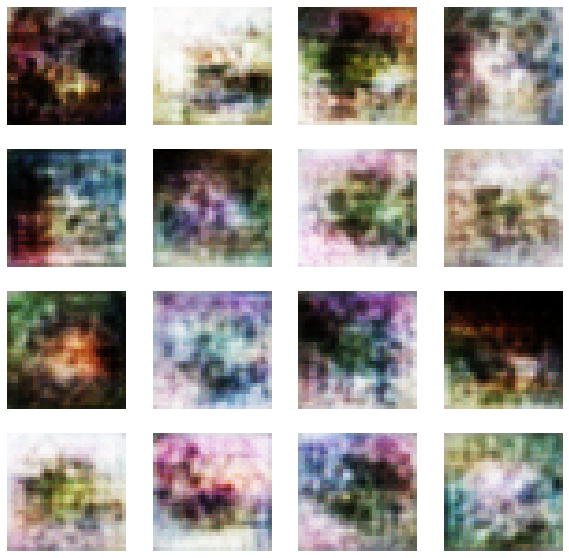

Time for training : 880 sec


KeyboardInterrupt: ignored

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

잘 수렴하지 않아 이 역시 중단하였다.

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_2차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_2차시도.gif" style = "float:left; width:66%;">

<div style = "height: 50px;"></div>

# 3차 시도

## 설명
<hr/>

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">BATCH_SIZE</span> : 512로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : dropout 0.5로 모두 변경하기</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">EPOCHS</span> : 2000으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">모든 optimizer 학습률</span> : 1e-3로 변경</li>
</ul>

<div style = "height: 50px;"></div>

In [ ]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [ ]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [ ]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 512

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 생성자 모델
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_82 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_100 (LeakyReLU)  (None, 16384)            0         
                                                                 
 reshape_28 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_81 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_83 (Bat  (None, 8, 8, 128)      

In [ ]:
# 판별자 모델 - drop 0.5로 변경해보기 
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_103 (LeakyReLU)  (None, 16, 16, 64)       0         
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 dropout_21 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_10 (Flatten)        (None, 8192)            

In [ ]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/generated_samples3/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [ ]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/training_history3/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/training_checkpoints3'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# 5마다 저장함
save_every = 5
EPOCHS = 2000

In [ ]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

KeyboardInterrupt: ignored

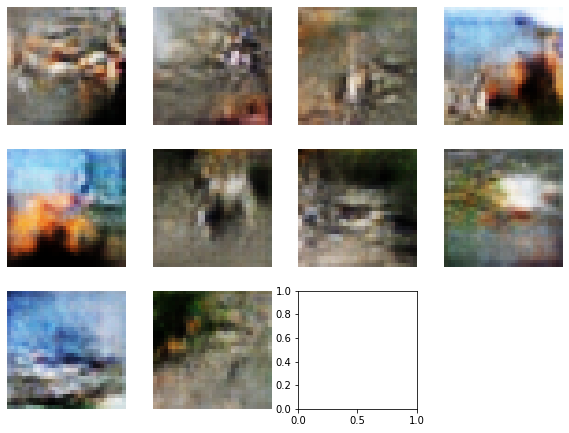

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

놀랍게도 loss값이 줄어들었으며, 미미하지만 fake accuracy가 줄어드는 것을 확인할 수 있었다. 

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_3차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_3차시도.gif" style = "float:left; width:66%;">

<div style = "height: 50px;"></div>

# 4차 시도

## 설명
<hr/>

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">BATCH_SIZE</span> : 1024로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_generator_model</span> : 7층으로 더 깊게 쌓음</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : 6층으로 더 깊게 쌓음</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : dropout 0.4로 모두 변경하기</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">옵티마이저</span> : Nadam으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">학습률</span> : 0.001로 변경</li>
</ul>

<div style = "height: 50px;"></div>

In [65]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [66]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [67]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 1024

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [69]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(2*2*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((2, 2, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 7: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              102400    
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 2, 2, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 2, 2, 128)       

In [70]:
# 판별자 모델 - drop 0.5로 변경해보기 
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
        
    # 3: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    # 4: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))   
    
    # 5: Flatten Layer
    model.add(layers.Flatten())

    # 6: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          102464    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)        

In [71]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work6/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [72]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work6/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [73]:
disc_tape# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.Nadam(0.001)
discriminator_optimizer = tf.keras.optimizers.Nadam(0.001)

In [74]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work6/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [75]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 60 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [76]:
# 5마다 저장함
save_every = 10
EPOCHS = 300

In [77]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

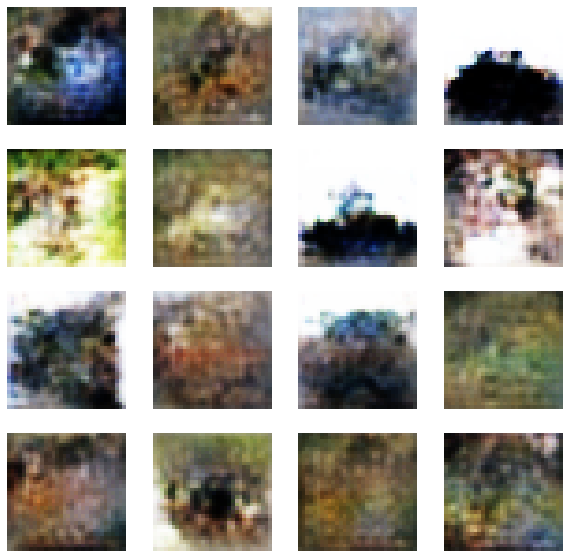

Time for training : 2584 sec


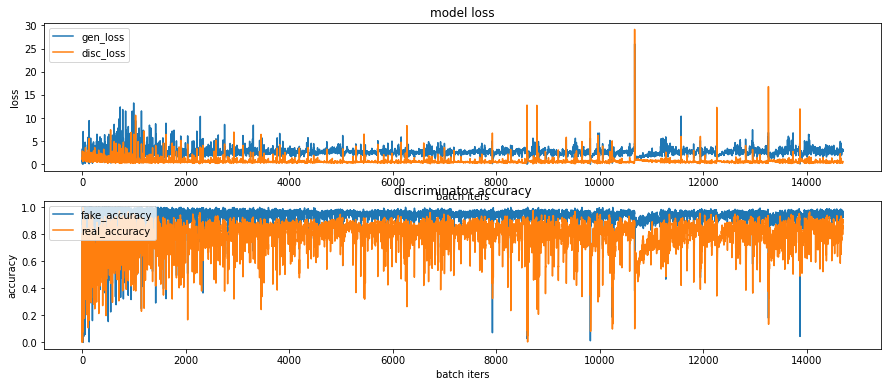

CPU times: user 44min 18s, sys: 29.3 s, total: 44min 48s
Wall time: 43min 6s


In [78]:
%%time
train(train_dataset, EPOCHS, save_every)

모델의 loss값은 서서히 하향하는데에 비해, accuracy는 중간중간에 떨어질 뿐, 전체적인 값은 1을 유지하고있다.

<div style = "height: 50px;"></div>

# 5차 시도

## 설명
<hr/>

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">BATCH_SIZE</span> : 256으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_generator_model</span> : 7층으로 깊게 쌓음</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : 7층으로 깊게 쌓은 후 dropout 0.4로 모두 변경하기</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">옵티마이저</span> : SGD로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">학습률</span> : 0.001로 변경</li>
</ul>

<div style = "height: 50px;"></div>

In [196]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [197]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [198]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [199]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(2*2*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((2, 2, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 7: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    # 2: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    # 3: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
        
    # 4: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    # 5: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))   
    
    # 6: Flatten Layer
    model.add(layers.Flatten())

    # 7: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

In [204]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [205]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work7/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [206]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work7/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [22]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.SGD(0.001)
discriminator_optimizer = tf.keras.optimizers.SGD(0.001)

In [208]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work7/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [209]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [210]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [211]:
# 5마다 저장함
save_every = 5
EPOCHS = 500

KeyboardInterrupt: ignored

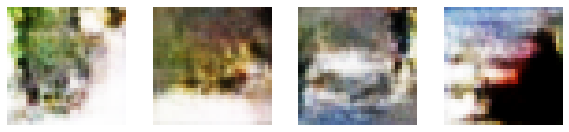

In [213]:
%%time
train(train_dataset, EPOCHS, save_every)

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_5차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_5차시도.gif" style = "float:left; width:66%;">

loss는 학습을 진행할 수록 줄어드는 것에 비해, <br/>
초반에는 fake accuracy가 1에서 0.8을 기준으로 값이 변동되었으나, 학습이 진행될 수록 변동 폭이 줄어들고 1에 점점 가까워지는 모습을 보여 학습을 중단하였다.

<div style = "height: 50px;"></div>

# 6차 시도해보기

## 설명
<hr/>

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">BATCH_SIZE</span> : 512로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_generator_model</span> : 7층으로 깊게 쌓음</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : 7층으로 깊게 쌓고 dropout을 2개만 추가하며 값을 0.2로 지정함</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">모든 활성화 함수</span> : ReLU로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">옵티마이저</span> : RMSprop로 변경 후 학습률을 0.0002로 변경함</li>
</ul>

<div style = "height: 50px;"></div>

In [225]:
cifar10 = tf.keras.datasets.cifar10

# 데이터셋 불러오기
(train_x, _), (test_x, _) = cifar10.load_data()

In [226]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5

In [227]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 512

In [228]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(2*2*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((2, 2, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 7: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2, 2, 128)         0

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.ReLU())
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
        
    # 3: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    
    # 4: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
    # 5: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
    # 6: Flatten Layer
    model.add(layers.Flatten())

    # 7: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
re_lu_6 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
re_lu_7 (ReLU)               (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)         

In [235]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [236]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work9/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [237]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work9/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [21]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.RMSprop(0.0002)
discriminator_optimizer = tf.keras.optimizers.RMSprop(0.0002)

In [238]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work9/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [239]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [240]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [241]:
# 5마다 저장함
save_every = 30
EPOCHS = 500

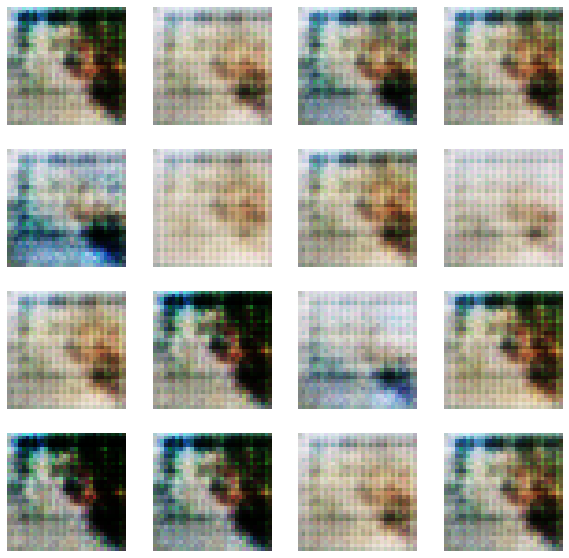

Epoch 34 | iter 251
Time for epoch 34 : 10 sec


KeyboardInterrupt: 

In [39]:
%%time
train(train_dataset, EPOCHS, save_every)

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_6차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_6차시도.gif" style = "float:left; width:66%;">

loss값은 gen loss와  disc loss가 역전되는 구간이 약 2번 있었다. 그렇다는 것은 fake accuracy가 낮은 구간이 꽤나 많았다는 것인데, accuracy를 확인한 결과, fake accuracy의 변동 폭이 클 뿐, fake accuracy가 1에 고정되어있는 것을 확인할 수 있었다. <br/>
그에 비해 real accuracy는 0.2에서 0.5를 기점으로 움직이고 있으며 이는 판별자의 진짜 샘플에 대한 판별 능력이 떨어지고 있는 것이다.

<div style = "height: 50px;"></div>

## 7차 시도해보기

## 설명
<hr/>

맨 처음 모델의 체크포인트를 불러와서 모델 학습 다시 진행해보기

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">모델 불러워</span> : 512로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : dropout 0.4로 모두 변경하기</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">EPOCHS</span> : 300으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">generator_optimizer</span> : 0.01로 변경</li>
</ul>

In [327]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 512

In [328]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

In [10]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
        
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [333]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [334]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [335]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work10/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [336]:
generator_optimizer = tf.keras.optimizers.Adam(0.01)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [337]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [343]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [348]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [349]:
# 5마다 저장함
save_every = 100
EPOCHS = 500

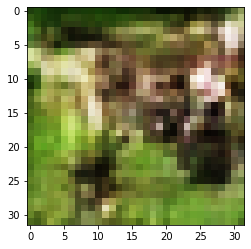

In [350]:
# 모델 로드 예시
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# %%time
# train(train_dataset, EPOCHS, save_every)

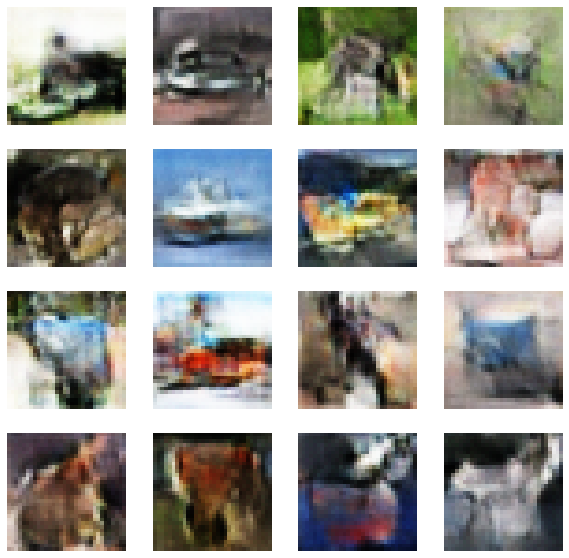

Time for training : 4555 sec


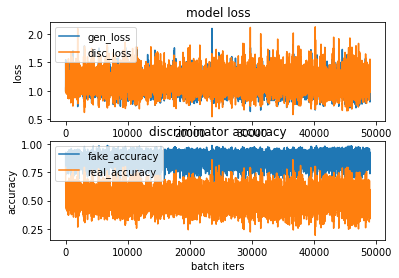

CPU times: user 1h 19min 6s, sys: 1min 8s, total: 1h 20min 14s
Wall time: 1h 15min 58s


In [351]:
%%time
train(train_dataset, EPOCHS, save_every)

가장 이미지가 잘 나온 모델이며, 그에 비해 accuracy는 처참한 것을 확인할 수 있었다.

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_7차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_7차시도.gif" style = "float:left; width:66%;">

<div style = "height: 50px;"></div>

## 8차 시도해보기

## 설명
<hr/>

맨 처음 모델의 체크포인트를 불러와서 모델 학습 다시 진행해보기

<ul>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">모델 불러워</span> : 512로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_generator_model</span> : Conv2D 레이어를 추가하고, 총 12층을 쌓에 모델 성능의 향상을 도모하였다.</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">make_discriminator_model</span> : dropout 0.2로 모두 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">EPOCHS</span> : 300으로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">generator_optimizer</span> : 학습률 0.0005로 변경</li>
    <li style = "margin-bottom:3px;"><span style = "font-weight:bold;color:#0172d4;">discriminator_optimizer</span> : 학습률 0.0001로 변경</li>
</ul>


In [327]:
# 전체 데이터를 섞기 위해 50,000으로 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 512

In [328]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [43]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(2*2*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 2: Reshape layer
    model.add(layers.Reshape((2, 2, 128)))
    
    # 3: Conv2D
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5: Conv2D
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 7: Conv2D
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 8: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 9: Conv2D
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 10: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  

    # 11: Conv2D
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 12: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               51200     
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 128)         409600    
_________________________________________________________________
batch_normalization_11 (Batc (None, 2, 2, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 2, 2, 128)        

In [46]:
# 판별자 모델 - drop 0.5로 변경해보기 
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [333]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [334]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [335]:
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex14/work10/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [52]:
# optimizer 정의하기
generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

In [337]:
# 모델 체크포인트 설정하기
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex14/work10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [343]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [348]:
# 모델 train 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [349]:
# 5마다 저장함
save_every = 100
EPOCHS = 500

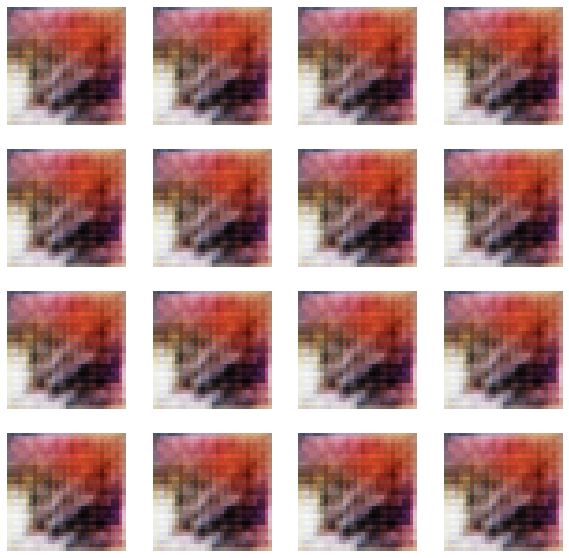

Time for training : 2559 sec


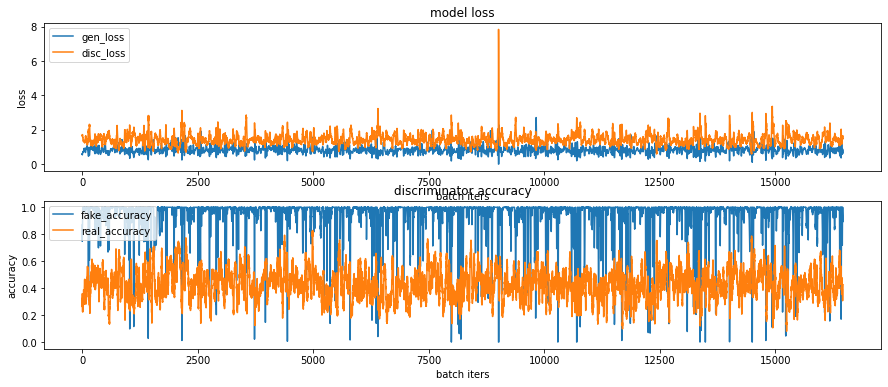

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

학습을 진행함에 있어 의미있는 이미지가 나오지 않아 중단하였으며, fake accuracy의 변동 폭이 큰 것에 비해 loss값이 적은 것을 확인할 수 있었다. 시간이 더 있었다면 모델을 불러와 좀 더 학습을 진행하였다면 fake accuracy의 변동 폭이 줄어들고, 운이 좋다면 아래로 내려갈 것이라고 판단하였다. 그러나 시간이 없으므로 여기까지만 학습을 진행하였다. 

<div style = "height: 50px;"></div>

## 결과 확인하기

<img src = "GIF/dcgan_8차시도.gif" style = "float:left; width:30%; margin-right:4%;">
<img src = "GIF/train_8차시도.gif" style = "float:left; width:66%;">

<div style = "height: 50px;"></div>

# 결론

## 1. best 모델
<hr/>

<img src = "GIF/best_img.png ">
<p style = "text-align:center; color:gray; font-size:16px;">[7차 시도 모델]</p>

- 가장 많은 횟수를 학습한 모델
- 약 1000번의 학습을 거쳐 출력된 이미지이다.
- loss값이 1 ~ 1.5 사이에서 움직이며 모델 중 가장 낮은 수치를 보인다.
- fake accuracy와 real accuracy가 0.5로 수렴하지 않고 1에 머무름 

<div style = "height: 50px;"></div>

## 2. 발전 가능성이 보이는 모델
<hr/>

# 회고하기